# time series classification

### 1. Загрузка библиотек

In [1]:
# import warnings
# warnings.filterwarnings('ignore')


import time
from scipy.stats import norm
from sklearn.base import clone
from tqdm import tqdm

# data
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.model_selection import train_test_split
# sktime
from sktime.datasets import load_airline
from sktime.datasets import load_arrow_head
# tslearn
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance
from tslearn.utils import save_time_series_txt, load_time_series_txt

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# model
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
# sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
# tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from tslearn.shapelets import LearningShapelets

np.random.seed(42)


ModuleNotFoundError: No module named 'tqdm'

In [17]:
def cm_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # Normalize
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cmn, cmap = 'Blues', annot = True, fmt = '.2f')
    sns.set(font_scale=1.3)
    plt.title('Confusion Matrix')
    return plt.show()

def print_table(accuracies, times):
    """Utility function to pretty print the obtained accuracies"""
    header_str = '|'
    header_str += '{:^20}|'.format('dataset')
    columns = ['sax error', 'sax time', 'eucl error', 'eucl time']
    for col in columns:
        header_str += '{:^12}|'.format(col)
    print(header_str)
    print('-'*(len(columns) * 13 + 22))

    for dataset in accuracies:
        acc_sax, acc_euclidean = accuracies[dataset]
        time_sax, time_euclidean = times[dataset]
        sax_error = np.around(1 - acc_sax, 5)
        eucl_error = np.around(1 - acc_euclidean, 5)
        time_sax = np.around(time_sax, 5)
        time_euclidean = np.around(time_euclidean, 5)
        s = '|'
        s += '{:>20}|'.format(dataset)
        s += '{:>12}|'.format(sax_error)
        s += '{:>12}|'.format(time_sax)
        s += '{:>12}|'.format(eucl_error)
        s += '{:>12}|'.format(time_euclidean)
        print(s.strip())

    print('-'*(len(columns) * 13 + 22))

## sktime airline and arrow head

### 2. Загрузка данных и разделение на тренировочную и тестовую выборку

In [15]:
# forecasting
data = load_airline()
print(data.shape)

# classification
X, y = load_arrow_head(return_X_y=True)
X_train , X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape)

(144,)
(158, 1) (158,)


In [11]:
data

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

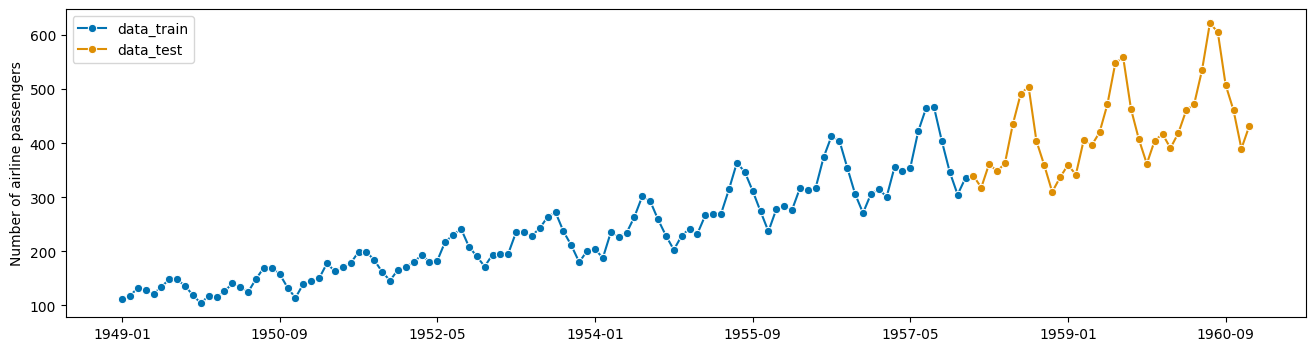

In [3]:
data_train, data_test = temporal_train_test_split(data)
plot_series(data_train, data_test, labels = ['data_train','data_test'])

In [12]:
X_train

,dim_0
120,0 -1.762354 1 -1.758315 2 -1.74198...
200,0 -1.805452 1 -1.798470 2 -1.76056...
156,0 -2.068266 1 -2.049443 2 -1.99982...
93,0 -1.803146 1 -1.800974 2 -1.78802...
0,0 -1.963009 1 -1.957825 2 -1.95614...
...,...
197,0 -0.658001 1 -0.636185 2 -0.60565...
110,0 -1.891357 1 -1.889370 2 -1.85313...
162,0 -1.829802 1 -1.843286 2 -1.81316...
13,0 -1.900535 1 -1.882731 2 -1.86845...


In [13]:
y_train

array(['1', '2', '1', '0', '0', '2', '2', '1', '1', '1', '1', '0', '1',
       '2', '0', '0', '0', '1', '0', '2', '2', '2', '1', '0', '1', '2',
       '0', '0', '0', '1', '2', '2', '0', '1', '1', '0', '1', '1', '1',
       '0', '2', '2', '0', '0', '2', '2', '1', '0', '1', '1', '2', '0',
       '0', '0', '0', '0', '1', '2', '2', '2', '1', '1', '1', '0', '1',
       '1', '0', '0', '0', '0', '2', '0', '0', '0', '0', '2', '0', '0',
       '0', '1', '0', '2', '2', '0', '1', '2', '0', '0', '1', '2', '1',
       '2', '1', '2', '0', '1', '0', '0', '1', '2', '2', '2', '0', '2',
       '1', '1', '0', '1', '0', '1', '2', '1', '1', '2', '0', '1', '2',
       '0', '0', '2', '0', '1', '0', '1', '2', '0', '0', '1', '0', '2',
       '2', '0', '1', '2', '0', '0', '1', '1', '0', '0', '2', '0', '1',
       '2', '0', '2', '2', '1', '2', '2', '1', '2', '0', '2', '1', '2',
       '1', '1'], dtype='<U1')

### 3. Эксперименты по прогнозированию

##### 3.1 Наивный баейсовский алгоритм

0.19886711926999853
0.23195770387951434
0.13189432350948402
0.145427686270316


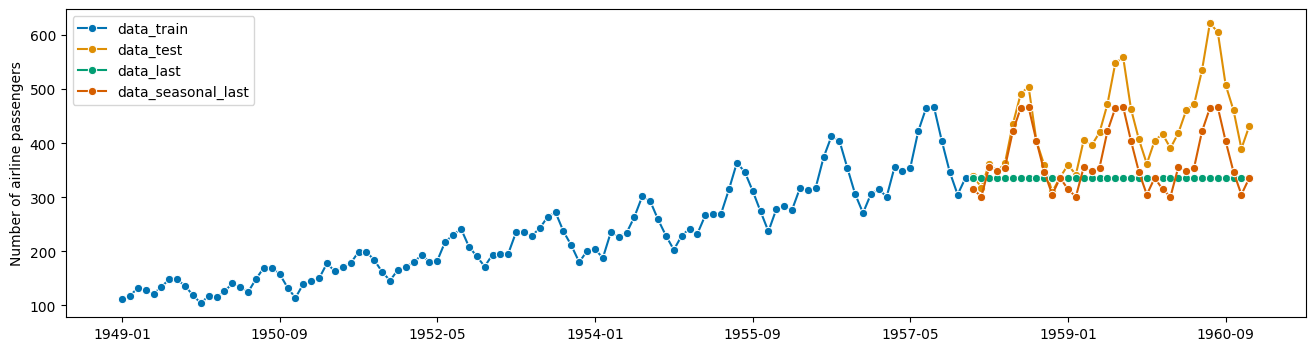

In [4]:
naive_forecaster_last = NaiveForecaster(strategy = 'last')
naive_forecaster_last.fit(data_train)

naive_forecaster_seasonal_last = NaiveForecaster(strategy = 'last', sp = 12) # 12 месяцев
naive_forecaster_seasonal_last.fit(data_train)

fh = ForecastingHorizon(data_test.index, is_relative=False) # fh = np.arange(len(y_test)) + 1  # forecasting horizon

data_last = naive_forecaster_last.predict(fh)
data_seasonal_last = naive_forecaster_seasonal_last.predict(fh)

plot_series(data_train, data_test, data_last, data_seasonal_last, labels = ['data_train', 'data_test', 'data_last', 'data_seasonal_last'])
print(mean_absolute_percentage_error(data_test, data_last, symmetric=False))
print(mean_absolute_percentage_error(data_test, data_last, symmetric=True))
print(mean_absolute_percentage_error(data_test, data_seasonal_last, symmetric=False))
print(mean_absolute_percentage_error(data_test, data_seasonal_last, symmetric=True))


##### 3.2 Взаимодействие с sklearn

0.12812287415313517


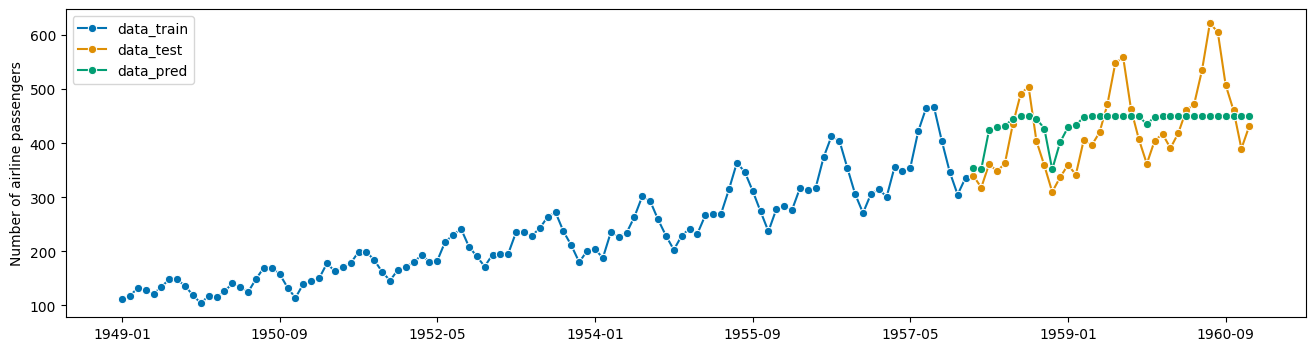

In [5]:
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, window_length=12, strategy='recursive')
forecaster.fit(data_train)
data_pred = forecaster.predict(fh)

plot_series(data_train, data_test, data_pred, labels = ['data_train', 'data_test', 'data_pred'])
print(mean_absolute_percentage_error(data_test, data_pred, symmetric=False))


#### 3.3 AutoARIMA

0.04166964128285063


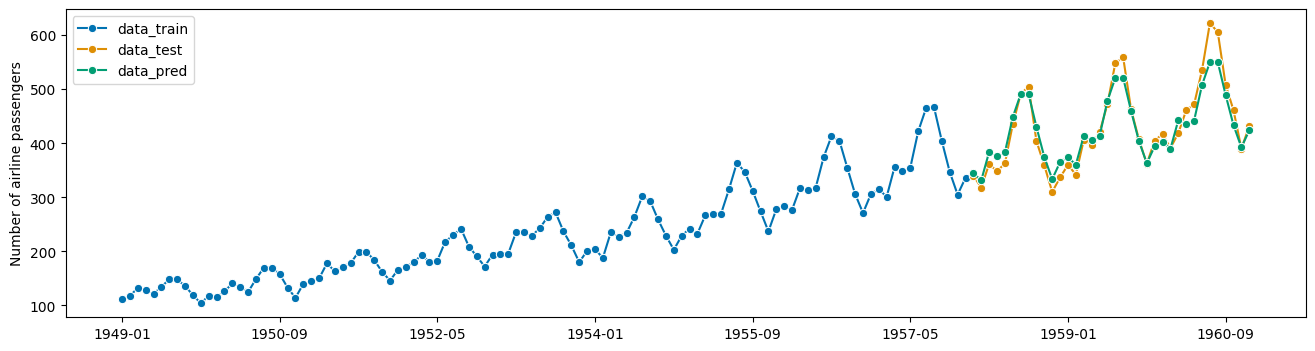

In [8]:
forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
forecaster.fit(data_train)
data_pred = forecaster.predict(fh)
plot_series(data_train, data_test, data_pred, labels=["data_train", "data_test", "data_pred"]);
print(mean_absolute_percentage_error(data_test, data_pred, symmetric=False))


### 4. Эксперименты по классификации

#### 4.1 Классификация одиночных временных рядов

In [16]:
clf = TimeSeriesForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8301886792452831

## tslearn UCR_UEA

### 2.1 Преобразование list в numpy (time series)


In [47]:
ts_0 = [1, 3, 4, 2] # time seires - list
ts_1 = [1, 2, 4, 2]
ts_2 = [1, 2, 3, 3, 3, -1]
ts_3 = [0, 3, 6]

formatted_ts_3 = to_time_series(ts_3)
formatted_ts_0 = to_time_series(ts_0)
formatted_ts_1 = to_time_series(ts_1)
formatted_ts_2 = to_time_series(ts_2)
print(formatted_ts_0)
print(type(formatted_ts_0), formatted_ts_0.shape)

formatted_dataset_0 = to_time_series_dataset([ts_0, ts_1])
print(formatted_dataset_0)
print(type(formatted_dataset_0), formatted_dataset_0.shape)

formatted_dataset_1 = to_time_series_dataset([ts_0, ts_1, ts_2])
print(formatted_dataset_1)
print(type(formatted_dataset_1), formatted_dataset_1.shape)

[[1.]
 [3.]
 [4.]
 [2.]]
<class 'numpy.ndarray'> (4, 1)
[[[1.]
  [3.]
  [4.]
  [2.]]

 [[1.]
  [2.]
  [4.]
  [2.]]]
<class 'numpy.ndarray'> (2, 4, 1)
[[[ 1.]
  [ 3.]
  [ 4.]
  [ 2.]
  [nan]
  [nan]]

 [[ 1.]
  [ 2.]
  [ 4.]
  [ 2.]
  [nan]
  [nan]]

 [[ 1.]
  [ 2.]
  [ 3.]
  [ 3.]
  [ 3.]
  [-1.]]]
<class 'numpy.ndarray'> (3, 6, 1)


In [76]:
print(formatted_ts_0)
print(' ')
print(TimeSeriesScalerMinMax(value_range = (0., 1.)).fit_transform([formatted_ts_0])) # На вход подается множество временных рядов
print(' ')
print(TimeSeriesScalerMinMax(value_range = (1., 2.)).fit_transform([formatted_ts_3]))
print(' ')
print(TimeSeriesScalerMinMax(value_range = (1., 2.)).fit_transform(formatted_dataset_1))

[[1.]
 [3.]
 [4.]
 [2.]]
 
[[[0.        ]
  [0.66666667]
  [1.        ]
  [0.33333333]]]
 
[[[1. ]
  [1.5]
  [2. ]]]
 
[[[1.        ]
  [1.66666667]
  [2.        ]
  [1.33333333]
  [       nan]
  [       nan]]

 [[1.        ]
  [1.33333333]
  [2.        ]
  [1.33333333]
  [       nan]
  [       nan]]

 [[1.5       ]
  [1.75      ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.        ]]]


In [75]:
print(formatted_ts_0)
print(' ')
tssmv = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform([ts_0]) # mu - среднее значение выходного временного ряда, std - стандартное отклонение выходного временного ряда
mu = tssmv.sum() / 4.
print(tssmv, mu, '\n', ' ')
print(TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform([formatted_ts_0])) # mu - среднее значение выходного временного ряда, std - стандартное отклонение выходного временного ряда

[[1.]
 [3.]
 [4.]
 [2.]]
 
[[[-1.34164079]
  [ 0.4472136 ]
  [ 1.34164079]
  [-0.4472136 ]]] -1.3877787807814457e-17 
  
[[[-1.34164079]
  [ 0.4472136 ]
  [ 1.34164079]
  [-0.4472136 ]]]


In [78]:
print(formatted_ts_0)
print(' ')
print(TimeSeriesResampler(sz=5).fit_transform([ts_0]))
print(' ')
print(TimeSeriesResampler(sz=10).fit_transform([ts_0]))
print(' ')
print(TimeSeriesResampler(sz=6).fit_transform(formatted_dataset_1))


[[1.]
 [3.]
 [4.]
 [2.]]
 
[[[1. ]
  [2.5]
  [3.5]
  [3.5]
  [2. ]]]
 
[[[1.        ]
  [1.66666667]
  [2.33333333]
  [3.        ]
  [3.33333333]
  [3.66666667]
  [4.        ]
  [3.33333333]
  [2.66666667]
  [2.        ]]]
 
[[[ 1. ]
  [ 2.2]
  [ 3.2]
  [ 3.8]
  [ 3.2]
  [ 2. ]]

 [[ 1. ]
  [ 1.6]
  [ 2.4]
  [ 3.6]
  [ 3.2]
  [ 2. ]]

 [[ 1. ]
  [ 2. ]
  [ 3. ]
  [ 3. ]
  [ 3. ]
  [-1. ]]]


### 2.2 Загрузка временных рядов из текстового файла

In [81]:
ts_dataset_0 = load_time_series_txt('ts_dataset.txt') # path/to/your/file.txt
save_time_series_txt('ts_dataset_new.txt', formatted_dataset_1)
print(ts_dataset_0)

[[[1.    3.   ]
  [0.    2.   ]
  [2.5   1.   ]]

 [[1.    4.333]
  [2.    2.12 ]
  [  nan   nan]]]


### 2.3 Загрузка данных UCR_UEA

Данные уже разделены на тренировочную и тестовую выборки. Временные ряды tslearn представляют собой трехмерные массивы или списки двухмерных массивов

In [22]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('FaceFour')
print(X_train.shape, y_train.shape)

(24, 350, 1) (24,)


In [21]:
print(X_train[0], X_train[0].shape)
print(' ')
print(X_train[0][0])

[[ 3.51570233e+00]
 [ 1.40286763e+00]
 [ 1.40286763e+00]
 [-3.30108713e-01]
 [-3.30108713e-01]
 [-5.91919737e-01]
 [-5.91919737e-01]
 [-5.91919737e-01]
 [-3.96931242e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-1.64037478e-01]
 [-1.64037478e-01]
 [-1.64037478e-01]
 [-5.14978362e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-5.11777886e-01]
 [-6.29825006e-01]
 [-6.29825006e-01]
 [-1.64037478e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-3.96931242e-01]
 [-5.14978362e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-6.29825006e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-3.96931242e-01]
 [-5.14978362e-01]
 [-5.14978362e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-2.78884123e-01]
 [-5.27122453e-02]
 [-5.27122453e-02]
 [ 5.10576427e-01]
 [ 1.17063754e+00]
 [ 1.17063754e+00]
 [ 1.55100090e+00]
 [ 1.55100090e+00]
 [ 2.07550523e+00]
 [ 2.37307474e+00]
 [ 2.3730747

##### Classifier implementing the k-nearest neighbors vote for Time Series.

In [23]:
ts_scaler = TimeSeriesScalerMeanVariance()
X_train_mv = ts_scaler.fit_transform(X_train)
X_test_mv = ts_scaler.fit_transform(X_test)

accuracies = {}
times = {}

clf_knn_sax = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric='sax')
clf_knn_eucl = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='euclidean')

# Fit 1-NN using SAX representation & MINDIST
metric_params = {'n_segments': 128, 'alphabet_size_avg': 10}
clf_knn_sax = clone(clf_knn_sax).set_params(metric_params=metric_params)
start = time.time()
clf_knn_sax.fit(X_train_mv, y_train)
y_pred = clf_knn_sax.predict(X_test_mv)
acc_clf_knn_sax = accuracy_score(y_test, y_pred)
time_sax = time.time() - start

# Fit 1-NN using euclidean distance on raw values
start = time.time()
clf_knn_eucl.fit(X_train_mv, y_train)
y_pred = clf_knn_eucl.predict(X_test_mv)
acc_clf_knn_eucl = accuracy_score(y_test, y_pred)
time_eucl = time.time() - start

accuracies['FaceFour'] = (acc_clf_knn_sax, acc_clf_knn_eucl)
times['FaceFour'] = (time_sax, time_eucl)

print_table(accuracies, times)

|      dataset       | sax error  |  sax time  | eucl error | eucl time  |
--------------------------------------------------------------------------
|            FaceFour|     0.14773|     0.56642|     0.21591|     0.01896|
--------------------------------------------------------------------------


##### Time-series specific Support Vector Classifier.

Correct classification rate: 0.45454545454545453


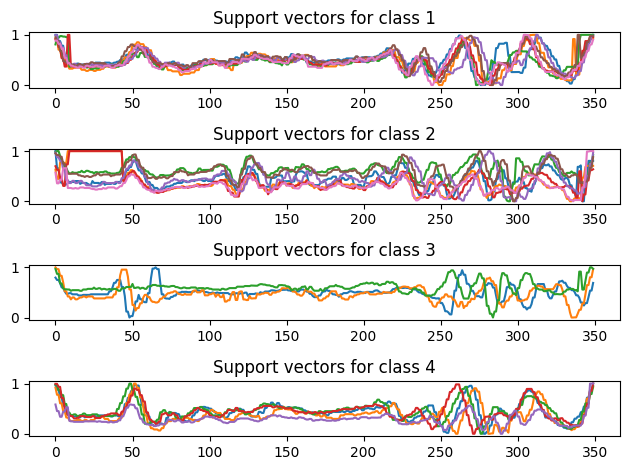

In [24]:
X_train_mm = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test_mm = TimeSeriesScalerMinMax().fit_transform(X_test)
n_classes = len(set(y_train))

clf_SVC = TimeSeriesSVC(C = 1., kernel = 'gak', gamma = 'auto', probability=True)
clf_SVC.fit(X_train_mm, y_train)
print("Correct classification rate:", clf_SVC.score(X_test_mm, y_test))
y_pred = clf_SVC.predict(X_test_mm)
y_pred_proba = clf_SVC.predict_proba(X_test_mm)
y_pred_log_proba = clf_SVC.predict_log_proba(X_test_mm)

plt.figure()
sv = clf_SVC.support_vectors_
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    plt.title('Support vectors for class %d' %cl)
    for ts in sv[i]:
        plt.plot(ts.ravel())

plt.tight_layout()
plt.show()


## ECG (classification)

### 2 Загрузка данных
Данные уже разделены на тренировочную и тестовую выборки

In [25]:
X_train = np.load('data/train_x.npy')
X_test = np.load('data/test_x.npy')
y_train = np.load('data/train_y.npy')

print(X_train.shape, X_test.shape)

(14667, 187) (7225, 187)


##### sktime KNeighborsTimeSeriesClassifier

In [28]:
clf = KNeighborsTimeSeriesClassifier(distance='euclidean')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average = 'macro')

TypeError: __init__() got an unexpected keyword argument 'distance'

In [ ]:
cm_plot(y_test, y_pred)

##### sktime TimeSeriesForestClassifier

In [ ]:
best_est = 3
best_f1 = 0

for est in tqdm(range(5, 42, 2)):
    for min_interval in range(3, 20):
        clf = TimeSeriesForestClassifier(n_estimators=est, min_interval=min_interval)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average = 'macro')

        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_min_interval = min_interval
